In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 19

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 80)                3440      
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 19)                779       
                                                                 
Total params: 7,459
Trainable params: 7,459
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
82/94 [=========================>....] - ETA: 0s - loss: 2.5460 - accuracy: 0.2490
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
94/94 [==============================] - 2s 8ms/step - loss: 2.4940 - accuracy: 0.2661 - val_loss: 1.8960 - val_accuracy: 0.4630
Epoch 2/1000
92/94 [============================>.] - ETA: 0s - loss: 1.8019 - accuracy: 0.4446
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 1.8002 - accuracy: 0.4448 - val_loss: 1.2742 - val_accuracy: 0.6037
Epoch 3/1000
83/94 [=========================>....] - ETA: 0s - loss: 1.4797 - accuracy: 0.5065
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 1.4674 - accuracy: 0.5134 - val_loss: 0.9937 - val_accuracy: 0.6788
Epoch 4/1000
79/94 [========================>.....] - ETA: 0s - loss: 1.3142 - accuracy: 0.5440
E

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

32/32 [==============================] - 0s 4ms/step - loss: 0.3321 - accuracy: 0.8933


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 251ms/step
[1.2751379e-02 1.5130278e-06 2.1006622e-07 6.7745475e-04 4.7442587e-03
 2.5534844e-06 6.8929836e-07 7.2288820e-08 2.1393974e-03 8.4778894e-04
 6.2272605e-04 8.3604139e-01 9.1650739e-02 5.3928792e-04 5.9194289e-08
 4.3872136e-05 3.3833592e-06 4.9904890e-02 2.8380518e-05]
11


# 混同行列

125/125 [==============================] - 0s 3ms/step


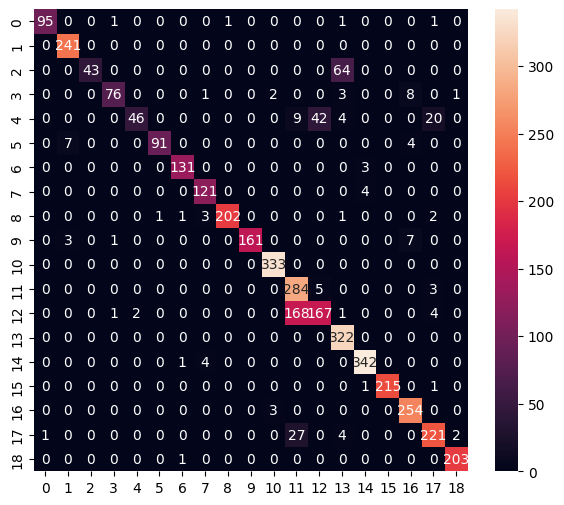

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        99
           1       0.96      1.00      0.98       241
           2       1.00      0.40      0.57       107
           3       0.96      0.84      0.89        91
           4       0.96      0.38      0.54       121
           5       0.99      0.89      0.94       102
           6       0.98      0.98      0.98       134
           7       0.94      0.97      0.95       125
           8       1.00      0.96      0.98       210
           9       1.00      0.94      0.97       172
          10       0.99      1.00      0.99       333
          11       0.58      0.97      0.73       292
          12       0.78      0.49      0.60       343
          13       0.81      1.00      0.89       322
          14       0.98      0.99      0.98       347
          15       1.00      0.99      1.00       217
          16       0.93      0.99      0.96       257
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\tanta\AppData\Local\Temp\tmp4br_ig1g\assets


INFO:tensorflow:Assets written to: C:\Users\tanta\AppData\Local\Temp\tmp4br_ig1g\assets


12376

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.2347246e-02 1.1562605e-06 1.4770100e-07 5.5303017e-04 4.2843018e-03
 1.8513958e-06 6.5275970e-07 5.4347975e-08 1.9611416e-03 8.4134954e-04
 5.5257545e-04 8.4283090e-01 9.1401801e-02 4.5233441e-04 4.7632540e-08
 3.9332997e-05 2.6334103e-06 4.4701606e-02 2.7918253e-05]
11
